## IDL Assignment 2

Rowan Mascarenhas - ID: 1797865 - 4/27/24

Text classification:
The dataset used is another movie review dataset from IMDB. It may be the same one from the 'tf2_text_classifier' file as it also has 50,000 entries, split evenly between training and test data.

This is a CNN model (Convolutional Neural Network), that attempts to track user sentiment in twitter posts reviewing movies.



##Note the the loss function and optimizer is only defined when the model is defined further down.

In [1]:
# Import libraries

!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# Set seed
seed = 42
np.random.seed(seed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Call dataset
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
# Data preview
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Define train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:15000]
train_sentiments = sentiments[:15000]

test_reviews = reviews[15000:]
test_sentiments = sentiments[15000:]

## Preprocessing

Function 'strip_html_tags' takes a text input and removes HTML tags using BeautifulSoup.

Function 'remove_accented_chars' does the same for accented characters.

Finally, 'pre_process_corpus' is the main function calling the 2 above, while also replaces special characters with spaces.

In [8]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters + whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [9]:
# Process the train and test datasets to the same standard
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  5%|▍         | 694/15000 [00:00<00:08, 1673.76it/s]<ipython-input-8-6e112d5e52c8>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 35000/35000 [00:22<00:00, 1562.02it/s]

CPU times: user 30.3 s, sys: 348 ms, total: 30.6 s
Wall time: 31.3 s


In [30]:
# Next, every review needs to be mapped to an index, to be called by the model, as an ID of sorts.

t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [11]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('relinquishing', 104916), ('<PAD>', 0), 1)

In [12]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [13]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [14]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=104917
Number of Documents=15000


### Sequence Normalization

To further ensure standardization, all reviews are set to 1000 characters. Longer reviews are truncated, shorter ones have filler '0's.

In [15]:
MAX_SEQUENCE_LENGTH = 1000

In [16]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((15000, 1000), (35000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using sklearn's LabelEncoder

In [17]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [18]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [27]:
VOCAB_SIZE = len(t.word_index)
print(VOCAB_SIZE)

104917


## Model Creation

The CNN is defined as a sequential model. 3 instances of 1D convolutional layers are added with varying numbers of filters, similar to image classification tasks seen in past class examples.

The model is flattened and the dense layers are added as the output layers. Finally, the model is compiled with the binary cross-entropy loss function, Adam optimizer, and accuracy metric.

In [20]:
# Define variables here to make changes easier (for model training)

EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

In [21]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         31475100  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

## Train Model


In [22]:
history = model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/10
106/106 [==============================] - 448s 4s/step - loss: 0.5438 - accuracy: 0.6727 - val_loss: 0.2795 - val_accuracy: 0.8907
Epoch 2/10
106/106 [==============================] - 446s 4s/step - loss: 0.1792 - accuracy: 0.9322 - val_loss: 0.2611 - val_accuracy: 0.8973
Epoch 3/10
106/106 [==============================] - 443s 4s/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.4105 - val_accuracy: 0.8867
Epoch 4/10
106/106 [==============================] - 465s 4s/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.5258 - val_accuracy: 0.8853
Epoch 5/10
106/106 [==============================] - 438s 4s/step - loss: 4.4037e-04 - accuracy: 0.9999 - val_loss: 0.6161 - val_accuracy: 0.8853
Epoch 6/10
106/106 [==============================] - 442s 4s/step - loss: 1.0900e-04 - accuracy: 1.0000 - val_loss: 0.6534 - val_accuracy: 0.8827
Epoch 7/10
106/106 [==============================] - 461s 4s/step - loss: 5.4510e-05 - accuracy: 1.0000 - val_loss: 0.6864 - val_accu

## Model Evaluation

In [23]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1094/1094 [==============================] - 261s 238ms/step - loss: 0.7745 - accuracy: 0.8830
Accuracy: 88.30%


In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

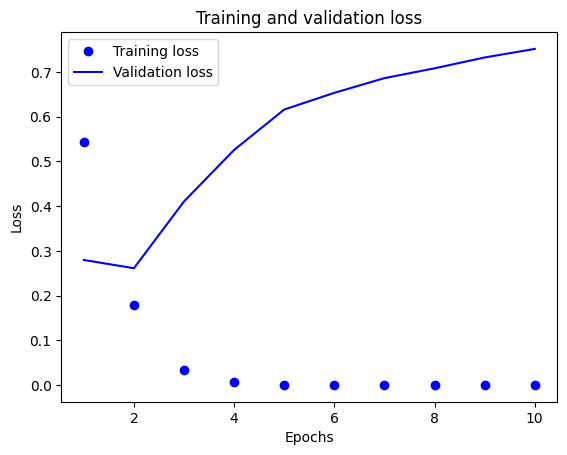

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

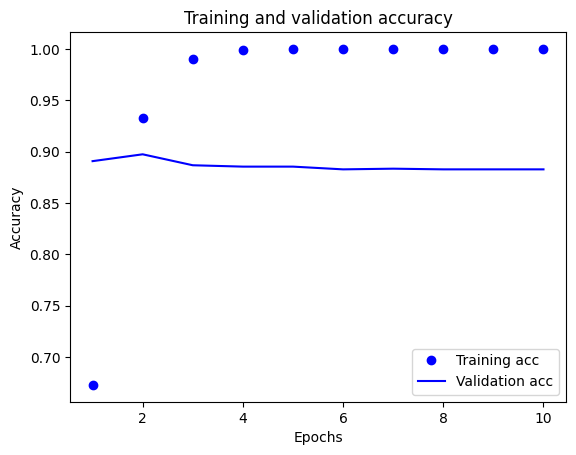

In [26]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

As the training and test data results vary, with the validation loss in particular becoming worse with more iterations (epoches).

This may be improved with a larger validation dataset. As for the accuracy, it doesn't change much beyond the first 2 iterations. Despite this, the overall model accuracy for this dataset is around 88%.